# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv('environment.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
btc = 1.2
eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
import json # Use json library to make data more readable
btc_request = requests.get(btc_url).json()
btc_price = btc_request['data']['1']['quotes']['CAD']['price']

print (json.dumps(btc_price, indent = 4))
# Fetch current ETH price
eth_request = requests.get(eth_url).json()
eth_price = eth_request['data']['1027']['quotes']['CAD']['price']

print (json.dumps(eth_price, indent = 4))

# Compute current value of my crpto
my_btc = btc_price*btc
my_eth = eth_price*eth

# Print current crypto wallet balance
print(f"The current value of your {btc} BTC is ${my_btc:0.2f}")
print(f"The current value of your {eth} ETH is ${my_eth:0.2f}")

38065.17
2413.59261
The current value of your 1.2 BTC is $45678.20
The current value of your 5.3 ETH is $12792.04


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
api_key = os.getenv('ALPACA_API_KEY')
api_secret = os.getenv('ALPACA_SECRET_KEY')

# Create the Alpaca API object
alpaca = tradeapi.REST(api_key, api_secret, api_version='v2')
alpaca

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2022-03-24", tz = "America/New_york").isoformat()


# Set the tickers
tickers = ["AGG", "SPY"]


# # Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_ticker = alpaca.get_bars(tickers,
                            timeframe,
                            start = today,
                            end = today).df

# Reorganize the DataFrame
# Separate ticker data
agg_data = df_ticker[df_ticker['symbol'] == 'AGG'].drop('symbol', axis = 1)


spy_data = df_ticker[df_ticker['symbol'] == 'SPY'].drop('symbol', axis = 1)


# Concatenate the ticker DataFrames
agg_spy_data = pd.concat([agg_data, spy_data], axis = 1, keys = ['AGG', 'SPY'], join = 'inner')

# Preview DataFrame
agg_spy_data

AGG                                    \
                             open     high     low   close   volume   
timestamp                                                             
2022-03-24 04:00:00+00:00  106.72  107.035  106.65  106.95  7378688   

                                                      SPY                 \
                          trade_count        vwap    open   high     low   
timestamp                                                                  
2022-03-24 04:00:00+00:00       23318  106.879605  445.94  450.5  444.76   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-03-24 04:00:00+00:00  450.49  61409702      526844  447.609058

In [9]:
# Pick AGG and SPY close prices
df_closing_price = pd.DataFrame()
df_closing_price['AGG'] = agg_spy_data['AGG']['close']
df_closing_price['SPY'] = agg_spy_data['SPY']['close']

#Using Iloc function to make the data look like just a number instead of a number with a bunch of contaminating information
agg_close_price = df_closing_price.iloc[0,0] 
spy_close_price = df_closing_price.iloc[0,1]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $106.95
Current SPY closing price: $450.49


In [10]:
# Compute the current value of shares
my_agg = 200
my_spy = 50
my_agg_value = my_agg*agg_close_price
my_spy_value = my_spy*spy_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22524.50
The current value of your 200 AGG shares is $21390.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
savings = {
    'crypto' : my_btc + my_eth,
    'shares' : my_spy_value+ my_agg_value
}

# Create savings DataFrame
df_savings = pd.DataFrame.from_dict(savings, orient = 'index') #found this function that sets my keys as indices
df_savings.rename(columns = {0 : 'amount'}, inplace = True) #Renamed the column to be 'amount'

# Display savings DataFrame
display(df_savings)

,amount
crypto,58470.244833
shares,43914.500000


<Axes: ylabel='amount'>

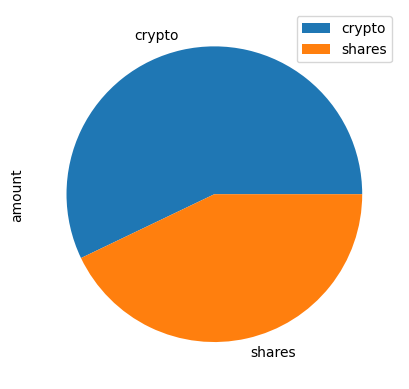

In [12]:
# Plot savings pie chart
df_savings.plot (kind = 'pie', y = 'amount')

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'][0] + df_savings['amount'][1]
total_savings

# Validate saving health
if (total_savings > emergency_fund):
    print (f'Congratulations, your total savings are ${(total_savings - emergency_fund):0.2f} more than you need!')
elif (total_savings == emergency_fund):
    print (f'Well, your total savings are equal to your emergency fund')
    
else:
    print (f'Warning! Your total savings are ${(total_savings - emergency_fund):0.2f} less than you need!')
    

Congratulations, your total savings are $66384.74 more than you need!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2018-03-25', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2023-03-25', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
df_stocks = alpaca.get_bars(tickers,
                                timeframe,
                                start = start_date,
                                end = end_date,
                                limit = 10000).df

# Reorganize the DataFrame
# Separate ticker data
agg_data = df_stocks[df_stocks['symbol'] == 'AGG'].drop('symbol', axis = 1)
spy_data = df_stocks[df_stocks['symbol'] == 'SPY'].drop('symbol', axis = 1)



# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg_data, spy_data], axis = 1, keys = ['AGG', 'SPY'], join = 'inner')

# Display sample data
df_stock_data.head()


AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2018-03-26 04:00:00+00:00  106.64  106.71  106.47  106.57  4546535   
2018-03-27 04:00:00+00:00  106.63  106.95  106.61  106.88  4566884   
2018-03-28 04:00:00+00:00  107.05  107.10  106.88  106.94  5617206   
2018-03-29 04:00:00+00:00  106.95  107.26  106.95  107.25  9199453   
2018-04-02 04:00:00+00:00  106.90  107.04  106.82  106.90  7280259   

                                                      SPY                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2018-03-26 04:00:00+00:00       19722  106.583861  262.13  265.43  259.4100   
2018-03-27 04:00:00+00:00       14293  106.826049  266.17  266.77  258.8400   
2018-03-28 04:00:00+00:00       18689  106.978133  260.75  262.64  258.5800   
2018-03-29 04:00:00+00:00       20364  107.212902  261.12  265.26  259.8389   
2018-04-02 04:00:00+00:00       24906  106.927635  262.55  263.13  254.6700   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2018-03-26 04:00:00+00:00  265.14  143141239      450168  262.353110  
2018-03-27 04:00:00+00:00  260.76  130806695      538201  263.145788  
2018-03-28 04:00:00+00:00  259.85  146510333      590467  260.395684  
2018-03-29 04:00:00+00:00  263.43  125470572      436558  262.835186  
2018-04-02 04:00:00+00:00  257.52  186324337      643544  258.212001

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
mc_simulation = MCSimulation(portfolio_data = df_stock_data,
                             weights = [0.6, 0.4],
                             num_simulation = 500,
                             num_trading_days = 252*30
                             )


# MC_even_dist = MCSimulation(
#     portfolio_data=df_ticker,
#     weights=[0.6, 0.2, 0.2],
#     num_simulation=500,
#     num_trading_days=252*5
# )



In [17]:
# Printing the simulation input data
mc_simulation.portfolio_data.head()

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2018-03-26 04:00:00+00:00  106.64  106.71  106.47  106.57  4546535   
2018-03-27 04:00:00+00:00  106.63  106.95  106.61  106.88  4566884   
2018-03-28 04:00:00+00:00  107.05  107.10  106.88  106.94  5617206   
2018-03-29 04:00:00+00:00  106.95  107.26  106.95  107.25  9199453   
2018-04-02 04:00:00+00:00  106.90  107.04  106.82  106.90  7280259   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2018-03-26 04:00:00+00:00       19722  106.583861          NaN  262.13   
2018-03-27 04:00:00+00:00       14293  106.826049     0.002909  266.17   
2018-03-28 04:00:00+00:00       18689  106.978133     0.000561  260.75   
2018-03-29 04:00:00+00:00       20364  107.212902     0.002899  261.12   
2018-04-02 04:00:00+00:00       24906  106.927635    -0.003263  262.55   

                                                                            \
                             high       low   close     volume trade_count   
timestamp                                                                    
2018-03-26 04:00:00+00:00  265.43  259.4100  265.14  143141239      450168   
2018-03-27 04:00:00+00:00  266.77  258.8400  260.76  130806695      538201   
2018-03-28 04:00:00+00:00  262.64  258.5800  259.85  146510333      590467   
2018-03-29 04:00:00+00:00  265.26  259.8389  263.43  125470572      436558   
2018-04-02 04:00:00+00:00  263.13  254.6700  257.52  186324337      643544   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-03-26 04:00:00+00:00  262.353110          NaN  
2018-03-27 04:00:00+00:00  263.145788    -0.016520  
2018-03-28 04:00:00+00:00  260.395684    -0.003490  
2018-03-29 04:00:00+00:00  262.835186     0.013777  
2018-04-02 04:00:00+00:00  258.212001    -0.022435

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
mc_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 110.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 120.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 130.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 140.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 150.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 160.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 170.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 180.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 190.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 200.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 210.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 220.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 230.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 240.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 250.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 260.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 270.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 280.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 290.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 300.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 310.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 320.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 330.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 340.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 350.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 360.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 370.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 380.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 390.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 400.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 410.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 420.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 430.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 440.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 450.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 460.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 470.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 480.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

Running Monte Carlo simulation number 490.


D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003336,1.002556,0.996720,0.991758,1.006943,0.994730,0.999509,1.002577,1.009525,1.006753,...,1.009179,1.003621,1.005802,0.994022,0.998715,1.000309,0.998459,1.000819,0.999519,1.007053
2,0.996968,1.006641,0.995102,0.997297,1.012897,0.984926,0.994852,0.993799,1.005628,1.009730,...,1.002086,1.000350,1.006623,0.997610,0.997006,0.995550,0.996672,1.008657,0.996909,0.995663
3,1.009476,1.000075,0.989980,0.996788,1.008588,0.989756,0.995684,0.991513,1.014007,1.011346,...,0.991563,0.987413,1.013314,0.992536,0.997315,0.988002,0.990770,1.008935,0.993462,0.992697
4,1.014868,1.001637,0.995216,1.001491,0.998068,0.982946,0.983871,0.984615,1.014084,1.014722,...,0.973696,0.984918,1.013452,0.986592,1.004771,0.986278,0.993927,1.016564,0.996303,0.989105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,3.871991,2.445660,1.723097,1.352578,3.524723,3.107457,1.733135,1.480288,2.940877,2.855919,...,4.148315,5.700181,5.053165,4.141199,0.871644,1.919567,2.276729,1.040945,3.041845,1.430366
7557,3.863958,2.455664,1.726167,1.346893,3.544888,3.109885,1.726432,1.482283,2.973742,2.857590,...,4.156339,5.631669,5.005921,4.154657,0.867629,1.917367,2.268555,1.042989,3.065447,1.417815
7558,3.865199,2.437240,1.734214,1.358895,3.528857,3.107903,1.733897,1.497758,2.953079,2.864495,...,4.166183,5.660689,5.006055,4.136204,0.869790,1.910117,2.269536,1.039559,3.043482,1.410831
7559,3.856391,2.433443,1.746371,1.371038,3.563367,3.075391,1.723677,1.506400,2.984732,2.857377,...,4.176734,5.705851,4.988683,4.147113,0.875337,1.914723,2.257076,1.045556,3.025093,1.421398


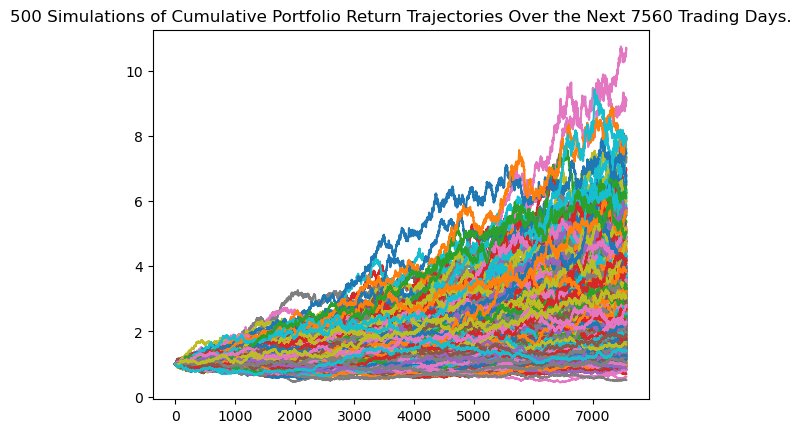

In [19]:
# Plot simulation outcomes
line_plot = mc_simulation.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

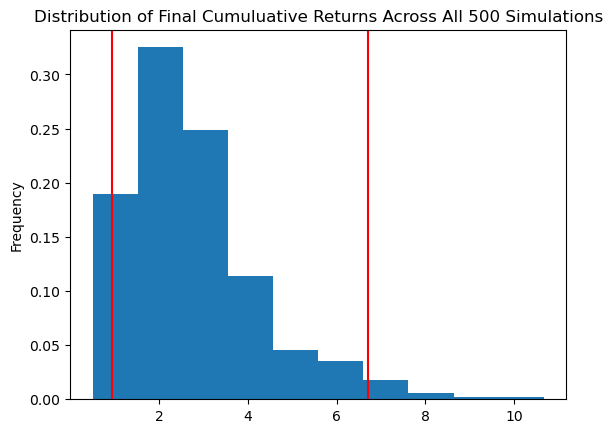

In [20]:
# Plot probability distribution and confidence intervals
mc_simulation.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_statistics = mc_simulation.summarize_cumulative_return()

# Print summary statistics
summary_statistics

D:\Downloads_Personal\FinTech_Course\Challenge_5\Starter_Code\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


count           500.000000
mean              2.788637
std               1.488155
min               0.509762
25%               1.709055
50%               2.478199
75%               3.431977
max              10.663150
95% CI Lower      0.944518
95% CI Upper      6.700633
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = summary_statistics[8]*initial_investment
ci_upper = summary_statistics[9]*initial_investment

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $18890.353118650368 and $134012.65611124577


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = summary_statistics[8]*initial_investment
ci_upper = summary_statistics[9]*initial_investment
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $28335.529677975555 and $201018.98416686867


## Optional Challenge - Early Retirement


### Five Years Retirement Option

# I feel bad, but I do not have enough time to deal with this challenge if it is optional.

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [26]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [27]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [29]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

NameError: name 'ci_lower_five' is not defined

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")